In [1]:
from utils import *
import numpy as np
import os
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertModel, logging
logging.set_verbosity_error()

### Open the preprocessed data, split into train, val and test

In [2]:
data = pd.read_csv("./data/spam_preprocessed.csv")
test_data=pd.read_csv("./data/test_data.csv")
gen_train=pd.read_csv("./data/generated_train_data.csv")
data=pd.concat([data, gen_train], ignore_index=True).sample(frac=1).reset_index(drop=True, )
train_data, val_data = train_test_split(data, test_size=0.1, random_state=2023)

print(train_data.shape, val_data.shape,test_data.shape)

(5735, 2) (638, 2) (160, 2)


### Initialize embedding model

In [3]:
embedding_model = BertModel.from_pretrained(
    "bert-base-uncased", output_hidden_states=True
)

### Get embeddings from from the data

In [4]:
X_train = create_embeddings(list(train_data["text"].values), embedding_model)
X_val = create_embeddings(list(val_data["text"].values), embedding_model)
X_test = create_embeddings(list(test_data["text"].values), embedding_model)

y_train = train_data["ham_spam_encoded"]
y_test = test_data["ham_spam_encoded"]
y_val = val_data["ham_spam_encoded"]

/home/server3090ti/anaconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [5]:
# creating fc model and weights
model_fc = fc_model_softmax(input_num=768)
weights_path = f"model/model.hdf5"  # path where will save model weights
model_fc.save_weights(
    weights_path
)  
# if we want to cancel learning and start from 0, if not comment the line
model_fc.load_weights(weights_path)

In [6]:
# defining epochs count, batch size and learning rate
epochs = 15
batch_size = 64
learning_rate = 0.001

In [7]:
X_test = to_tf(X_test)
X_train = to_tf(X_train)
X_val = to_tf(X_val)

In [8]:
data = (X_train, X_val, y_train, y_val)
history = trainer(
    model_fc, data, weights_path, batch_size, epochs, learning_rate=learning_rate
)

Epoch 1/15
76/90 [========================>.....] - ETA: 0s - loss: 0.2961
Epoch 1: val_loss improved from inf to 0.10147, saving model to model/model.hdf5
90/90 [==============================] - 2s 5ms/step - loss: 0.2673 - val_loss: 0.1015
Epoch 2/15
76/90 [========================>.....] - ETA: 0s - loss: 0.0769
Epoch 2: val_loss improved from 0.10147 to 0.04855, saving model to model/model.hdf5
90/90 [==============================] - 0s 4ms/step - loss: 0.0732 - val_loss: 0.0486
Epoch 3/15
80/90 [=========================>....] - ETA: 0s - loss: 0.0459
Epoch 3: val_loss improved from 0.04855 to 0.04608, saving model to model/model.hdf5
90/90 [==============================] - 0s 4ms/step - loss: 0.0466 - val_loss: 0.0461
Epoch 4/15
78/90 [=========================>....] - ETA: 0s - loss: 0.0424
Epoch 4: val_loss did not improve from 0.04608
90/90 [==============================] - 0s 4ms/step - loss: 0.0418 - val_loss: 0.0581
Epoch 5/15
90/90 [==============================] - ET

In [9]:
tp, tn, fp, fn = get_metrics(model_fc, weights_path, X_test, y_test)

print(f"----- Accuracy = \t{(tp+tn)/(tp + tn + fp + fn):.2%} -----")
print(f"----- Precision = \t{tp/(tp + fp):.2%} -----")
print(f"----- Recall =  \t{tp/(tp + fn):.2%} -----")

----- Accuracy = 	93.75% -----
----- Precision = 	97.30% -----
----- Recall =  	90.00% -----


### Training and validation loss

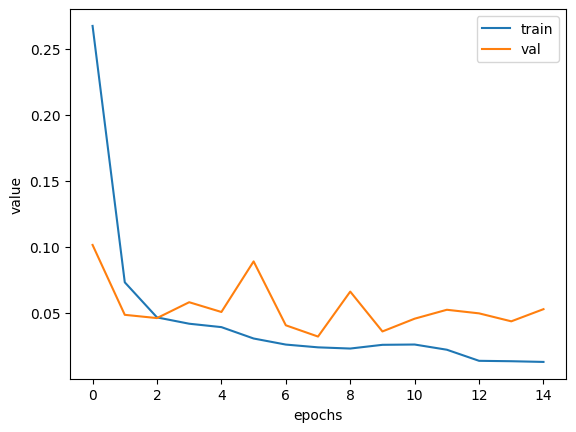

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "val"])
plt.xlabel("epochs")
plt.ylabel("value")
plt.show()

### Confusion matrix

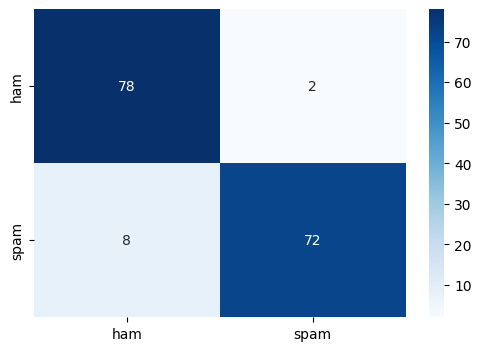

In [11]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 4))
class_labels = ["ham", "spam"]
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.show()